In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/Combined Data.csv',)

In [ ]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
df.shape

(53043, 2)

In [ ]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [ ]:
df.status.value_counts()

,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


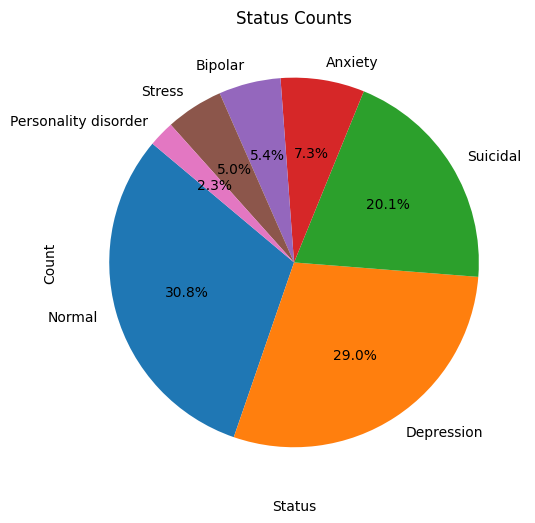

In [ ]:
status_counts = df['status'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status Counts')
plt.show()


In [ ]:
trainig_df = df.sample(frac=0.6, random_state=42)
validation_df = df.sample(frac=0.2, random_state=42)
test_df = df.sample(frac=0.2, random_state=42)


In [ ]:
trainig_df.shape, validation_df.shape, test_df.shape

((31826, 2), (10609, 2), (10609, 2))

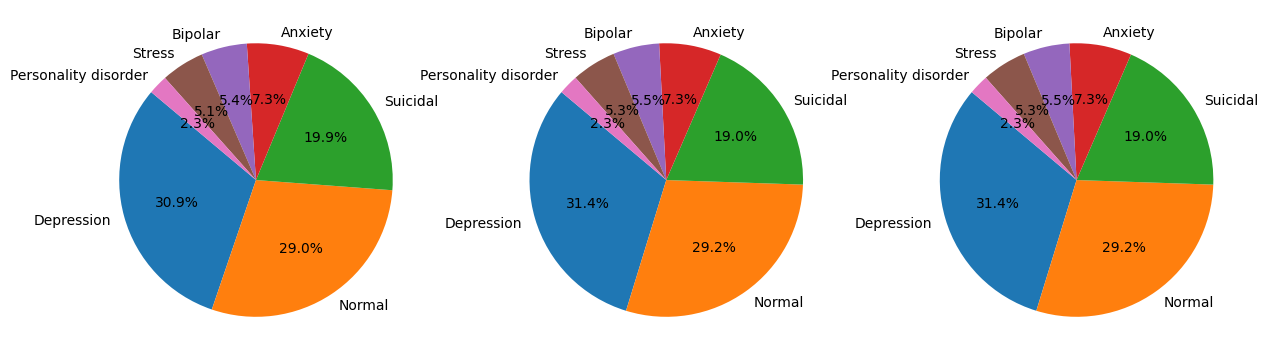

In [ ]:
trainig_df.status.value_counts()
validation_df.status.value_counts()
test_df.status.value_counts()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pie(trainig_df['status'].value_counts(), labels=trainig_df['status'].unique(), autopct='%1.1f%%', startangle=140)
plt.subplot(1, 3, 2)
plt.pie(validation_df['status'].value_counts(), labels=validation_df['status'].unique(), autopct='%1.1f%%', startangle=140)
plt.subplot(1, 3, 3)
plt.pie(test_df['status'].value_counts(), labels=test_df['status'].unique(), autopct='%1.1f%%', startangle=140)
plt.show()

In [ ]:
tr_text = trainig_df['statement']
tr_label = trainig_df['status']

val_text = validation_df['statement']
val_label = validation_df['status']

ts_text = test_df['statement']
ts_label = test_df['status']

In [ ]:
tr_text.shape, val_text.shape, ts_text.shape, tr_label.shape, val_label.shape, ts_label.shape

((31826,), (10609,), (10609,), (31826,), (10609,), (10609,))

In [ ]:
tr_text = tr_text.astype(str)
val_text = val_text.astype(str)
ts_text = ts_text.astype(str)



In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()

In [ ]:
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text)

In [ ]:
sequences = tokenizer.texts_to_sequences(tr_text)

In [ ]:
max_sequence_length = max(len(seq) for seq in sequences)
max_sequence_length

6300

In [ ]:
tr_x = pad_sequences(sequences, maxlen=max_sequence_length)
tr_y = to_categorical(tr_label)

In [ ]:
sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=max_sequence_length)
val_y = to_categorical(val_label)

In [ ]:
sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=max_sequence_length)
ts_y = to_categorical(ts_label)

In [ ]:
max_words = 10000
max_len = max_sequence_length
embedding_dim = 32

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, ReLU, BatchNormalization, Concatenate, Conv1D, GlobalMaxPooling1D, Dropout, Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Inputs for both branches
input1 = Input(shape=(max_len,))
input2 = Input(shape=(max_len,))

# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

output1 = branch1(input1)  # Call branch1 on input1

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

output2 = branch2(input2)  # Call branch2 on input2

# Concatenation
concatenated = Concatenate()([output1, output2])

# Fully connected layers
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(7, activation='softmax')(dropout)

# Final model
model = Model(inputs=[input1, input2], outputs=output_layer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy', Precision(), Recall()])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 6300)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 6300)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64)             │        326,464 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64)             │        326,464 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 7)              │            903 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 670,343 (2.56 MB)

 Trainable params: 670,087 (2.56 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
batch_size = 256
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, batch_size=batch_size, epochs=epochs, validation_data=([val_x, val_x], val_y))

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.7255 - loss: 0.7159 - precision: 0.8027 - recall: 0.6471 - val_accuracy: 0.7949 - val_loss: 0.7845 - val_precision: 0.9123 - val_recall: 0.4989
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.7423 - loss: 0.6583 - precision: 0.8108 - recall: 0.6763 - val_accuracy: 0.7989 - val_loss: 0.6903 - val_precision: 0.8942 - val_recall: 0.5980
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - accuracy: 0.7553 - loss: 0.6249 - precision: 0.8125 - recall: 0.6954 - val_accuracy: 0.8230 - val_loss: 0.6256 - val_precision: 0.9039 - val_recall: 0.6447
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.7684 - loss: 0.5916 - precision: 0.8230 - recall: 0.7125 - val_accuracy: 0.8253 - val_loss: 0.5754 - val_precision: 0.8975 - val_recall: 0.6870
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accuracy: 0.7805 - loss: 0.5633 - precision: 0.8306 - recall: 0.7293 - val_accuracy: 0.8413

In [ ]:
(loss, accuracy, precision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}')

332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9792 - loss: 0.1555 - precision: 0.9872 - recall: 0.9634
Loss: 0.16, Accuracy: 0.98, Precision: 0.99, Recall: 0.96


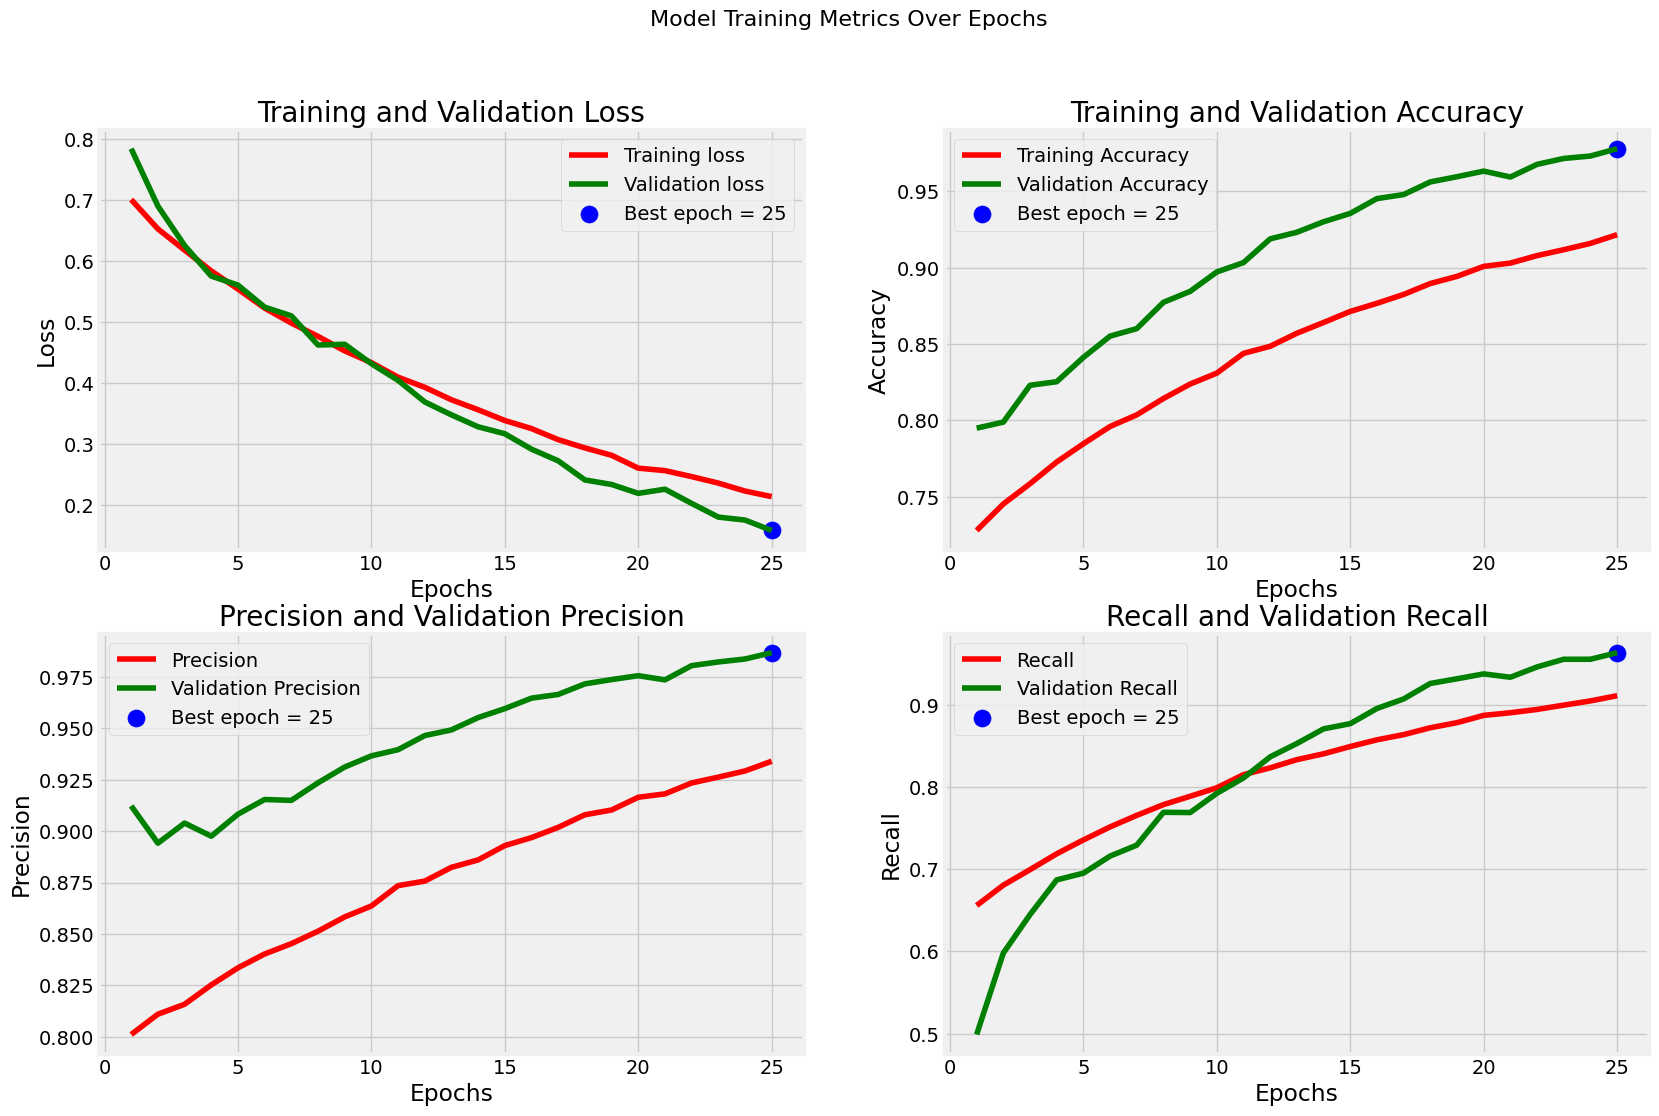

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
y_true=[]
for i in range(len(ts_y)):

    x = np.argmax(ts_y[i])
    y_true.append(x)

In [ ]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


array([2, 2, 2, ..., 2, 2, 3])

In [ ]:
encoder.classes_

array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal'], dtype=object)

<Axes: >

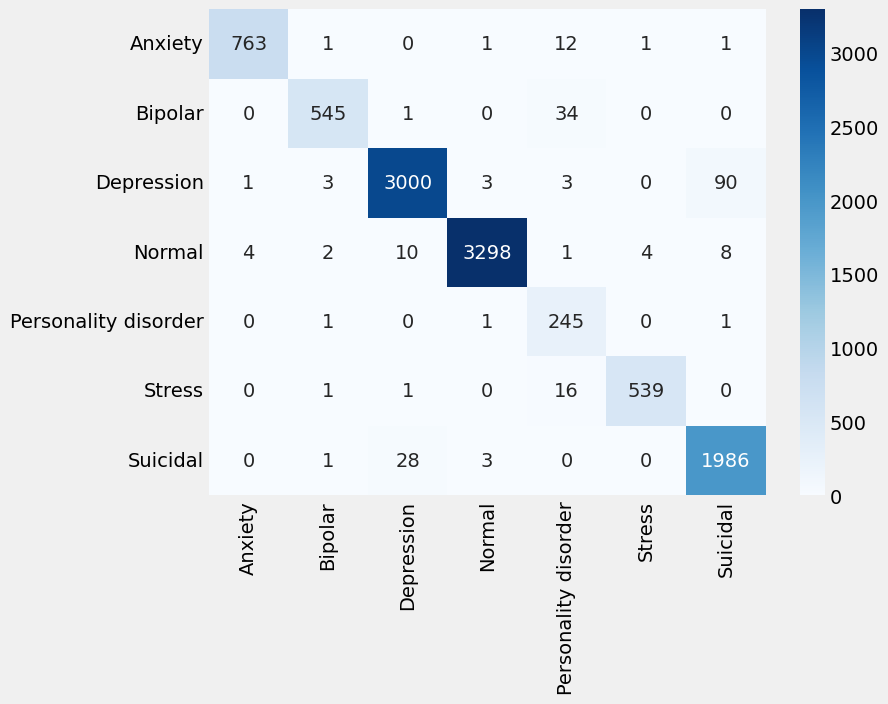

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(8,6))
emotions = {0: 'Anxiety', 1: 'Bipolar', 2: 'Depression', 3:'Normal',4:'Personality disorder',5:'Stress',6:'Suicidal'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [ ]:
clr = classification_report(y_true, y_pred, target_names=emotions)
print(clr)

                      precision    recall  f1-score   support

             Anxiety       0.99      0.98      0.99       779
             Bipolar       0.98      0.94      0.96       580
          Depression       0.99      0.97      0.98      3100
              Normal       1.00      0.99      0.99      3327
Personality disorder       0.79      0.99      0.88       248
              Stress       0.99      0.97      0.98       557
            Suicidal       0.95      0.98      0.97      2018

            accuracy                           0.98     10609
           macro avg       0.96      0.97      0.96     10609
        weighted avg       0.98      0.98      0.98     10609



In [ ]:
import pickle

In [ ]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('model.h5')

In [ ]:
def predict_emotion(text, model_path, token_path):

    with open(token_path, 'rb') as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
    model = tf.keras.models.load_model(model_path)

    sequences = tokenizer.texts_to_sequences([text])
    x = pad_sequences(sequences, maxlen=6300)
    prediction = model.predict([x,x])

    emotions = {0: 'Anxiety', 1: 'Bipolar', 2: 'Depression', 3:'Normal',4:'Personality disorder',5:'Stress',6:'Suicidal'}


    label = list(emotions.values())
    probs = list(prediction[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()



In [ ]:
text = 'Imagine waking up only hanging on by a thread and then you get a call from your bank that you lost $9000 to fraud from a possible job posting. Not to be dramatic but at this point I am convinced that life enjoys torturing me. And I am not sure how much longer I can be it is joke I am life\'s rag doll'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


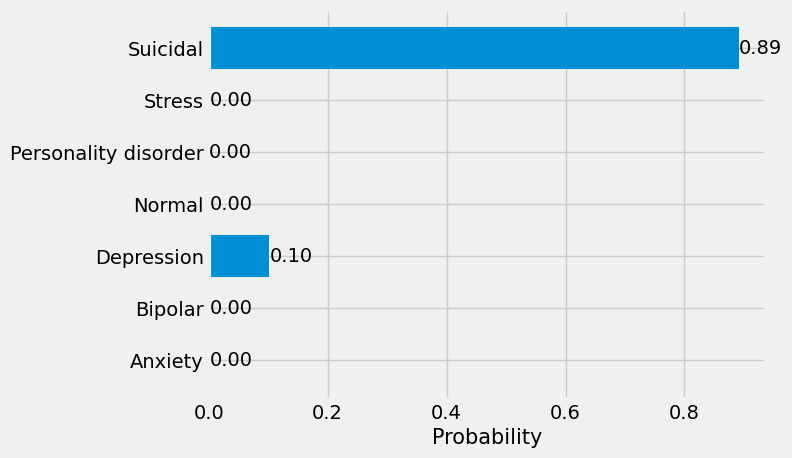

In [ ]:
predict_emotion(text, 'model.h5', 'tokenizer.pkl')

In [ ]:
\